In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt


import torchvision.datasets as dset
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.transforms.functional
from torchvision.transforms import v2
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import AdamW
from tqdm import tqdm
import math
import torch.nn.functional as F

import numpy as np
from torchmetrics.image.inception import InceptionScore

In [2]:
# select device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
# DEVICE = torch.device('cpu')
print(f'{DEVICE=}')

# hyper param

DATASET = 'CIFAR10'  # CIFAR10 or MNIST
print(f'{DATASET=}')
if DATASET == 'MNIST':
    IMG_SIZE = (32, 32, 1) # original images are padded to make size 32 x 32
    DATASET = MNIST
elif DATASET == 'CIFAR10':
    IMG_SIZE = (32, 32, 3)
    DATASET = CIFAR10
print(f'{IMG_SIZE=}')

BATCH_SIZE = 64
N_LAYERS = 8
HIDDEN_DIM = 256
HIDDEN_DIMS = [HIDDEN_DIM for _ in range(N_LAYERS)]
N_TIMESTAMPS = 1000
TIMESTAMP_EMBED_DIM = 256
# BETA_MIN_MAX = [1e-4, 2e-2]
LEARNING_RATE = 5e-5
N_EPOCH = 20

# prepare data

dataset_path = '/tmp/cifar10_dataset'
transform = transforms.Compose([
    transforms.Resize(32), transforms.ToTensor()
])  # TODO: try subtract mean & div by std
# transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.uint8, scale=False)])
train_dataset = DATASET(dataset_path, transform=transform,
                        train=True, download=True)
eval_dataset = DATASET(dataset_path, transform=transform,
                       train=True, download=True)
test_dataset = DATASET(dataset_path, transform=transform,
                       train=False, download=True)
NUM_DATASET = len(train_dataset)
# NUM_DATASET = 1000  # use a smaller dataset
NUM_TRAIN = int(NUM_DATASET * 0.8)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
# train_sample = list(train_loader)[0][0]

# print(train_dataset.data.type())
# print(train_dataset.data.float().mean(), train_dataset.data.min(), train_dataset.data.max(), train_dataset.data.shape)
# print(train_sample.mean(), train_sample.min(), train_sample.max(), train_sample.shape)

eval_loader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE,
                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_DATASET)))
test_loader = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE)

N_CLASS = len(train_dataset.classes)
print(f'{N_CLASS=} {NUM_TRAIN=}')
print(train_dataset.classes)

DEVICE=device(type='cuda')
DATASET='CIFAR10'
IMG_SIZE=(32, 32, 3)
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
N_CLASS=10 NUM_TRAIN=40000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
from typing import Tuple, Optional

import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn

import math
from typing import Optional, Tuple, Union, List

ENABLE_CLASS_EMBEDDING = True

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)


class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = nn.SiLU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

class ClassEmbedding(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        in_channels = # of classes
        out_channels = embedding dimension
        """
        super().__init__()
        self.embedding_layer = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.SiLU(),
            nn.Linear(out_channels, out_channels)
        )
        self.in_channels = in_channels

    def forward(self, class_: torch.Tensor):
        assert class_.shape[1] == self.in_channels
        return self.embedding_layer(class_)


class ResidualBlock(nn.Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(
                in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = nn.SiLU()

        if ENABLE_CLASS_EMBEDDING:
            self.class_emb = nn.Linear(time_channels, out_channels)
            self.class_act = nn.SiLU()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor, c):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))

        if ENABLE_CLASS_EMBEDDING:
            h *= self.class_emb(self.class_act(c))[:, :, None, None]

        # Add time embeddings
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        # Add the shortcut connection and return
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    """
    ### Attention block

    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(
            batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=2)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor, c):
        x = self.res(x, t, c)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(
            in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor, c):
        x = self.res(x, t, c)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor, c):
        x = self.res1(x, t, c)
        x = self.attn(x)
        x = self.res2(x, t, c)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(
            n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor, c):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels,
                              kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor, c):
        # return F.max_pool2d(x, kernel_size=2)
        return self.conv(x)


class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (
                     False, False, True, True),
                 n_blocks: int = 2,
                 n_class: int = 10):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(
            image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels,
                            n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels,
                          n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels,
                      n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = nn.SiLU()
        self.final = nn.Conv2d(in_channels, image_channels,
                               kernel_size=(3, 3), padding=(1, 1))
        
        if ENABLE_CLASS_EMBEDDING:
            self.n_class = n_class
            self.class_embedding_layer = ClassEmbedding(self.n_class, n_channels * 4)

    def forward(self, x: torch.Tensor, time_step: torch.Tensor, class_: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        class_ has shape (batch_size, )
        """

        # Get time-step embeddings
        time_step_embedding = self.time_emb(time_step)

        # Get image projection
        x = self.image_proj(x)

        class_embedding = torch.tensor([])
        if ENABLE_CLASS_EMBEDDING:
            class_one_hot = nn.functional.one_hot(class_, num_classes=self.n_class).type(torch.float)
            class_embedding = self.class_embedding_layer(class_one_hot)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, time_step_embedding, class_embedding)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, time_step_embedding, class_embedding)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, time_step_embedding, class_embedding)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, time_step_embedding, class_embedding)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))


class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_diffusion_timestep: int, device: torch.device):
        """
        * `eps_model` is $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        * `n_diffusion_timestep` is $t$
        * `device` is the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model

        # Create $\beta_1, \dots, \beta_T$ linearly increasing variance schedule
        # Cosine beta schedule
        def beta_at_t(t): return math.cos(
            (t + 0.008) / 1.008 * math.pi / 2) ** 2
        betas = []
        for i in range(n_diffusion_timestep):
            t1 = i / n_diffusion_timestep
            t2 = (i+1) / n_diffusion_timestep
            betas.append(min(1 - beta_at_t(t2) / beta_at_t(t1), 0.02))
        self.beta = torch.tensor(betas).to(device)
        # self.beta = torch.linspace(
        #     0.0001, 0.02, n_diffusion_timestep).to(device)

        self.device = device

        # $\alpha_t = 1 - \beta_t$
        self.alpha = 1. - self.beta
        # $\bar\alpha_t = \prod_{s=1}^t \alpha_s$
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # $T$
        self.n_diffusion_timestep = n_diffusion_timestep
        # $\sigma^2 = \beta$
        self.sigma2 = self.beta

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor, class_: torch.Tensor):
        eps_theta = self.eps_model(xt, t, class_)
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma2, t)
        eps = torch.randn(xt.shape, device=xt.device)
        return mean + (var ** .5) * eps

    def q(self, x0, t, eps=None):
        """
        Add noise from x0 to xt
        """
        if eps is None:
            eps = torch.randn_like(x0)
        noise_mean = torch.sqrt(gather(self.alpha_bar, t)) * x0
        noise_sd = torch.sqrt(1 - gather(self.alpha_bar, t))
        return noise_mean + noise_sd * eps

    def loss(self, x0: torch.Tensor, class_: torch.Tensor):
        batch_size = x0.shape[0]
        t = torch.randint(low=0, high=self.n_diffusion_timestep, size=(batch_size,),
                          device=x0.device, dtype=torch.long)

        eps = torch.randn_like(x0)

        xt = self.q(x0, t, eps)

        eps_theta = self.eps_model(xt, t, class_)

        return F.mse_loss(eps, eps_theta)


In [4]:
IMAGE_CHANNEL = IMG_SIZE[2]
eps_model = UNet(
    image_channels=IMAGE_CHANNEL,
    n_channels=64,
    ch_mults=[1, 2, 2, 4],
    is_attn=[False, False, False, True],
).to(DEVICE)

diffusion = DenoiseDiffusion(
    eps_model=eps_model,
    n_diffusion_timestep=N_TIMESTAMPS,
    device=DEVICE,
)

optimizer = Adam(eps_model.parameters(), lr=LEARNING_RATE)

Number of model parameters:  170017731
forwarding diffusion sampling...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4584) tensor(0.) tensor(1.) torch.Size([64, 3, 32, 32])


UNet(
  (image_proj): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): SiLU()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): SiLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_act): SiLU()
        (class_emb): Linear(in_features=256, out_features=64, bias=True)
        (class_act): SiLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2):

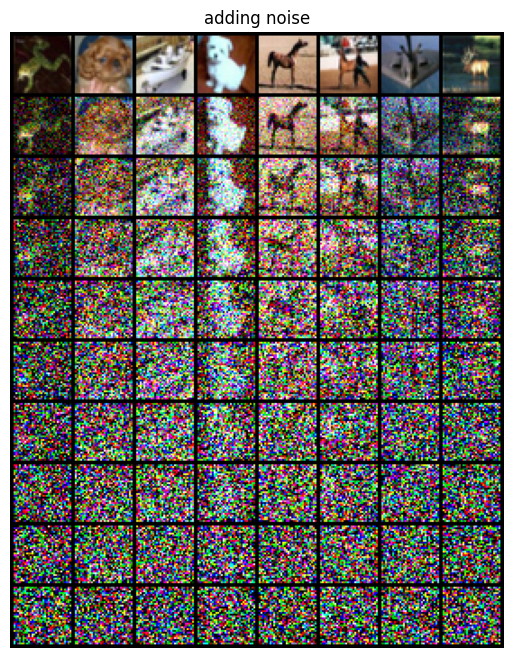

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from torchvision.transforms import v2

def show_image(image):
    """
    image has shape C, H, W
    """
    plt.figure()
    image = image.transpose(0, 1).transpose(1, 2).detach().cpu().numpy()
    plt.imshow(image)


def draw_sample_image(x, title):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(make_grid(x.detach().cpu(),
               padding=2, normalize=False), (1, 2, 0)))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of model parameters: ", count_parameters(eps_model))
print("forwarding diffusion sampling...")
eps_model.eval()
with torch.no_grad():
    for x, class_ in train_loader:
        print(x.mean(), x.min(), x.max(), x.shape)
        x = x[:8].to(DEVICE)
        xt = torch.tensor([]).to(DEVICE)
        for t in range(0, N_TIMESTAMPS, 100):
            xt = torch.cat((xt, diffusion.q(
                x, torch.full((8, ), t).to(DEVICE))))
#         xt = v2.ToDtype(torch.uint8, scale=True)(xt)
#         print(xt.mean(), xt.min(), xt.max(), xt.shape)
        
        draw_sample_image(xt, f"adding noise")
        break  # only sample 1 batch
eps_model.train()


start training
training epoch=0


100%|██████████| 625/625 [02:09<00:00,  4.82it/s]


training epoch=1


100%|██████████| 625/625 [02:09<00:00,  4.84it/s]


training epoch=2


100%|██████████| 625/625 [02:08<00:00,  4.87it/s]


training epoch=3


100%|██████████| 625/625 [02:17<00:00,  4.54it/s]


training epoch=4


100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


training epoch=5


100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


training epoch=6


100%|██████████| 625/625 [02:10<00:00,  4.78it/s]


training epoch=7


100%|██████████| 625/625 [02:18<00:00,  4.52it/s]


training epoch=8


100%|██████████| 625/625 [02:08<00:00,  4.85it/s]


training epoch=9


100%|██████████| 625/625 [02:07<00:00,  4.88it/s]


training epoch=10


100%|██████████| 625/625 [02:07<00:00,  4.91it/s]


training epoch=11


100%|██████████| 625/625 [02:18<00:00,  4.50it/s]


training epoch=12


100%|██████████| 625/625 [02:08<00:00,  4.88it/s]


training epoch=13


100%|██████████| 625/625 [02:08<00:00,  4.86it/s]


training epoch=14


100%|██████████| 625/625 [02:08<00:00,  4.85it/s]


training epoch=15


100%|██████████| 625/625 [02:16<00:00,  4.57it/s]


training epoch=16


100%|██████████| 625/625 [02:09<00:00,  4.81it/s]


training epoch=17


100%|██████████| 625/625 [02:07<00:00,  4.89it/s]


training epoch=18


100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


training epoch=19


100%|██████████| 625/625 [02:17<00:00,  4.54it/s]


ValueError: x and y must have same first dimension, but have shapes (116,) and (125,)

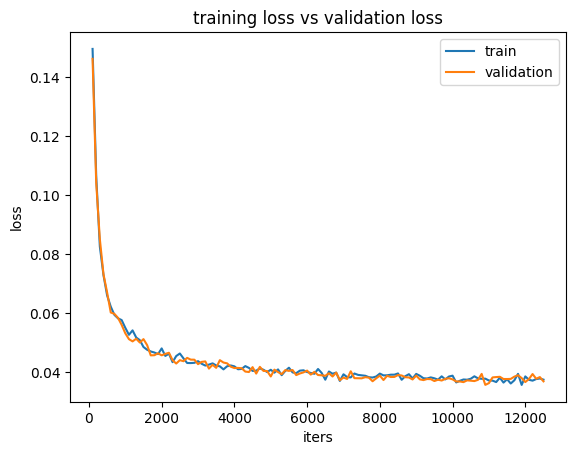

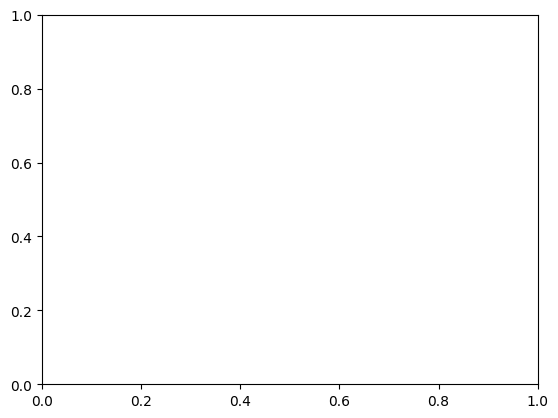

In [6]:
print("start training")

train_loss_arr = [0]
eval_loss_arr = [0]
iters = [0]

EVAL_EVERY_ITER = 100
EVAL_BATCH = 100

def evaluate():
    with torch.no_grad():
        eval_loss = 0.0
        train_loss = 0.0
        eps_model.eval()
        for train_batch_idx, (img_, class_) in enumerate(train_loader):
            train_loss += diffusion.loss(img_.to(DEVICE), class_.to(DEVICE)).item()
            if train_batch_idx > EVAL_BATCH:
                break
        for eval_batch_idx, (img_, class_) in enumerate(eval_loader):
            eval_loss += diffusion.loss(img_.to(DEVICE), class_.to(DEVICE)).item()
            if eval_batch_idx > EVAL_BATCH:
                break
        eval_loss /= eval_batch_idx
        train_loss /= train_batch_idx
        eval_loss_arr.append(eval_loss)
        train_loss_arr.append(train_loss)
        iters.append(iters[-1] + EVAL_EVERY_ITER)
        eps_model.train()

i = 0
for epoch in range(N_EPOCH):
    print(f'training {epoch=}')
    for batch_idx, (img_, class_) in tqdm(enumerate(train_loader), total=len(train_loader)):
        i += 1
        if i % EVAL_EVERY_ITER == 0:
            evaluate()
        
        optimizer.zero_grad()
        loss = diffusion.loss(img_.to(DEVICE), class_.to(DEVICE))
        loss.backward()
        optimizer.step()
        
            
plt.figure()
plt.plot(iters[1:], train_loss_arr[1:], label = 'train')
plt.plot(iters[1:], eval_loss_arr[1:], label = 'validation')
plt.xlabel('iters')
plt.ylabel('loss')
plt.legend()
plt.title('training loss vs validation loss')

plt.figure()
plt.plot(iters[10:], train_loss_arr[10:], label = 'train')
plt.plot(iters[10:], eval_loss_arr[10:], label = 'validation')
plt.xlabel('iters')
plt.ylabel('loss')
plt.legend()
plt.title('training loss vs validation loss')

sampling...


100%|██████████| 1000/1000 [00:28<00:00, 35.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sampling only cats...


100%|██████████| 1000/1000 [00:28<00:00, 34.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


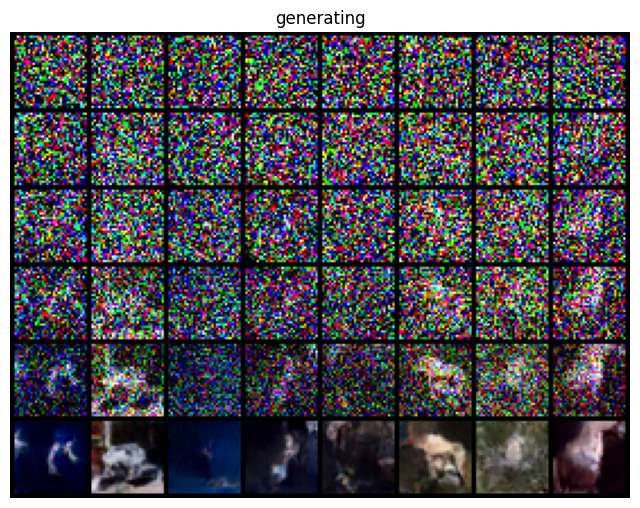

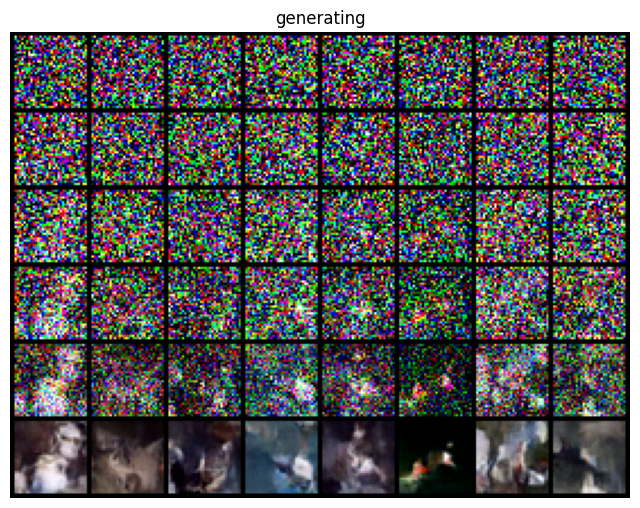

In [10]:
eps_model.eval()
print('sampling...')
class_ = torch.arange(8).to(DEVICE)
with torch.no_grad():
    x = torch.randn([8, IMAGE_CHANNEL, 32, 32], device=DEVICE)
    xt = torch.tensor([]).to(DEVICE)
    for t_ in tqdm(range(N_TIMESTAMPS)):
        t = N_TIMESTAMPS - t_ - 1
        t = x.new_full((1,), t, dtype=torch.long)
        x = diffusion.p_sample(x, t, class_)
        if t_ % 200 == 0 or t_ == N_TIMESTAMPS - 1:
            xt = torch.cat((xt, x))
    draw_sample_image(xt, f"generating")

print('sampling only cats...')
class_ = torch.full((8,),3).to(DEVICE) # 3 = cat
with torch.no_grad():
    x = torch.randn([8, IMAGE_CHANNEL, 32, 32], device=DEVICE)
    xt = torch.tensor([]).to(DEVICE)
    for t_ in tqdm(range(N_TIMESTAMPS)):
        t = N_TIMESTAMPS - t_ - 1
        t = x.new_full((1,), t, dtype=torch.long)
        x = diffusion.p_sample(x, t, class_)
        if t_ % 200 == 0 or t_ == N_TIMESTAMPS - 1:
            xt = torch.cat((xt, x))
    draw_sample_image(xt, f"generating")

Text(0.5, 1.0, 'training loss vs validation loss')

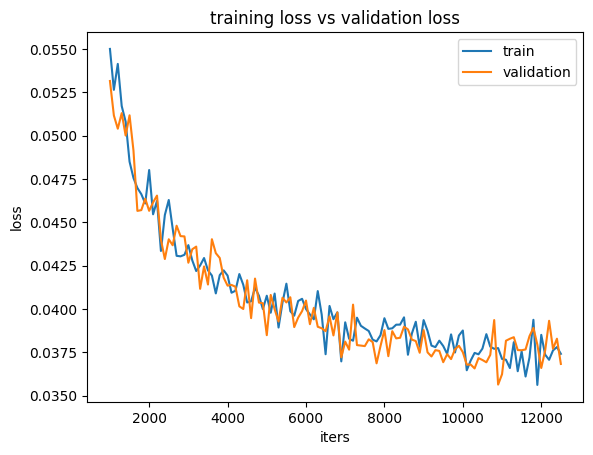

In [7]:
plt.figure()
plt.plot(iters[10:], train_loss_arr[10:], label = 'train')
plt.plot(iters[10:], eval_loss_arr[10:], label = 'validation')
plt.xlabel('iters')
plt.ylabel('loss')
plt.legend()
plt.title('training loss vs validation loss')